- **Nombre del candidato:** Juan Carlos Salazar Mesa
- **Fecha:** 08/08/2025
- **Email de contacto:** jucasamesa2@gmail.com

### Introducción

El equipo de Moderaciones IT (ModIT) dentro de Mercado Libre, se encarga de bloquear productos del marketplace que infringen políticas como derechos de autor, derechos de marca o aquellos cuyas imágenes no cumplen ciertos estándares de calidad. Estas bajas o moderaciones se pueden realizar manualmente o de forma automática, esta última siempre apoyada por modelos de Machine Learning que toman decisiones con base en los atributos (precio, marca, título, descripción, etc) y/o las imágenes de los productos.

Debido a que Mercado Libre tiene como prioridad en el 2022 el segmento de moda, ModIT está analizando todos los productos nuevos dentro del segmento de moda con el fin de moderar aquellos cuya imagen de portada no presente el producto en un fondo plano en color blanco o crema. Teniendo en cuenta que este trabajo está siendo realizado de forma manual por un equipo de 10 personas (moderadores) el análisis de ítems se limita a un total de 4,000 diarios. 

Ante esto nuestro equipo decide aceptar el reto y disparar un proceso de experimentación para identificar si podríamos o no generar algún recurso que apoye al equipo ModIT para automatizar el proceso y agregar valor a la experiencia laboral de los moderadores. 

A continuación te presentaremos 3 tareas comunes que nos enfrentamos como equipo al momento proponer una solución a algún problema planteado, para resolver cada una de ellas ten en cuenta los siguientes puntos:

1. Siéntete libre de realizar preguntas ante cualquier duda que se te presente. Estamos a un correo de distancia.
2. Los experimentos que realices deben ser replicables. Asegúrate de dejar disponible todo lo necesario para que podamos ejecutar tu código. Puedes usar archivos auxiliares como archivo de dependencias o scripts con funciones o clases.
3. Es importante que documentes lo que más puedas de tu código y dejes plasmado todas las ideas, procesos, experimentos, hipótesis y/o conclusiones que tuviste mientras estabas resolviendo el problema.
4. No esperamos una solución perfecta, para nosotros es más importante el proceso que planteas que el performance de la solución.

Mucha suerte!

### Parte I

Para el proceso de experimentación ModIT nos envía un archivo CSV (`training_data.csv`) con las siguientes columnas:
- **item_id:** Identificador único de item dentro del marketplace.
- **site_id:** País al que pertenece el ítem.
- **domain_id:** Categoría del marketplace a la que pertenece el ítem.
- **picture_id:** Identificador único de la imagen de portada del ítem. Con el *picture_id* podrás construir una url para descargar cada imagen, la estructura es la siguiente: https://http2.mlstatic.com/D_{picture_id}-F.jpg, e.g. http://http2.mlstatic.com/D_680853-MLM50014173158_052022-F.jpg
- **correct_background?:** 1 si el producto se presenta en un fondo apropiado, 0 de lo contrario.

En esta sección se requiere que realices los experimentos necesarios que permitan responder sí podemos o no dar solución al problema. 

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Para la parte I se utiliza el archivo `training_data.csv` para obtener las URLs y alimentar la función que procesa
import sys
from tqdm import tqdm

sys.path.append("../")

import pandas as pd
from src.data.preprocess import saving_images_in_local
from src.data.eda import load_image, extract_corner_stats, analyze_background_color, create_visualizations, analyze_all_images, is_that_color

In [3]:
path_csv_train = r"../data/raw/training_data.csv"
image_folder = r"../data/raw/img"

In [4]:
# saving_images_in_local(path_csv_train, image_folder)

In [5]:
# df, df2 = analyze_all_images(path_csv_train, image_folder)

In [6]:
df = pd.read_csv(path_csv_train, dtype=str)
df.shape

(4372, 5)

In [7]:
df['img_path'] = df['picture_id'].apply(lambda x: image_folder+f"/D_{x}-F.jpg")

#### Revision de funciones

In [95]:
image_path = df[df['img_path'].str.contains("D_820430-MLA49628611503_042022-F.jpg")]['img_path'].tolist()[0]
#df['img_path'][df['img_path'].sample(1, random_state=180).index[0]]

In [96]:
pil_image = Image.open(image_path)
cv_image = cv.cvtColor(np.array(pil_image), cv.COLOR_RGB2BGR)

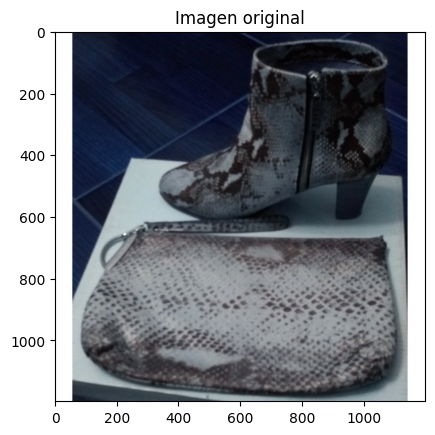

In [97]:
# Load image in BGR format (OpenCV default)
img = cv.imread(image_path)

plt.imshow(img)
plt.title('Imagen original')
plt.show()

In [15]:
array = load_image(image_path)

In [16]:
# Get array dimensions
height, width = array.shape[:2]
total_pixels = height * width

# Analyze different regions of the array (center, corners, edges)
regions = {
    'center': array[height//4:3*height//4, width//4:3*width//4],
    'top_left': array[:height//3, :width//3],
    'top_right': array[:height//3, 2*width//3:],
    'bottom_left': array[2*height//3:, :width//3],
    'bottom_right': array[2*height//3:, 2*width//3:]
    }

In [17]:
array.shape

(269, 536, 3)

In [18]:
height, width, total_pixels

(269, 536, 144184)

In [29]:
regions['center'].shape, regions['top_left'].shape

((252, 122, 3), (167, 81, 3))

In [8]:
df['array'] = df['img_path'].apply(load_image)

In [9]:
df['height'] = df['array'].apply(lambda x: x.shape[0])
df['width'] = df['array'].apply(lambda x: x.shape[1])
df['total_pixels'] = df['height']+df['width']

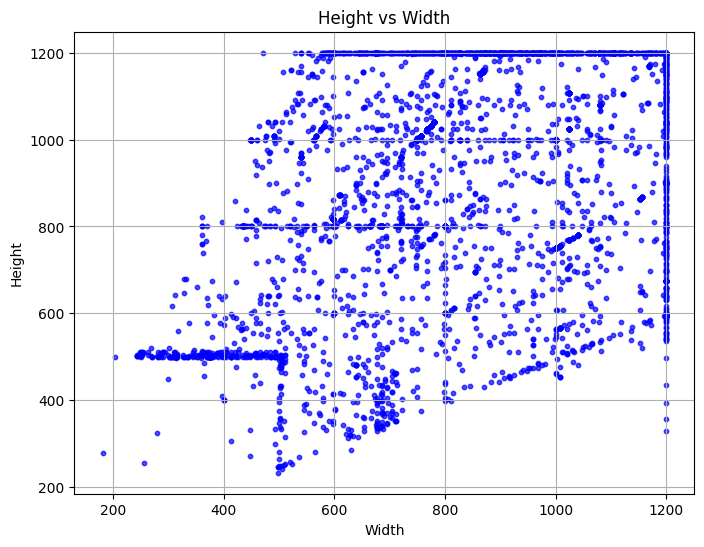

In [35]:
# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['width'], df['height'], color='blue', alpha=0.7, s=10)

# Add labels and title
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Height vs Width')
plt.grid(True)

# Show plot
plt.show()

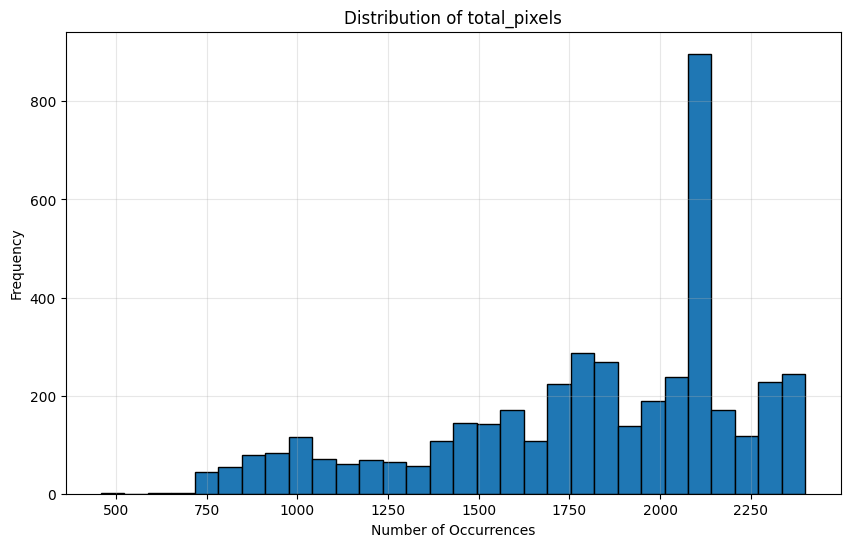

In [40]:
df['total_pixels'].plot(kind='hist', 
                                      bins=30, 
                                      edgecolor='black',
                                      figsize=(10, 6))

# Add labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.title('Distribution of total_pixels')
plt.grid(True, alpha=0.3)

plt.show()

In [10]:
df_list = []

for index in range(0, df.shape[0]):

    temp_df = pd.DataFrame(data=extract_corner_stats(df['array'][index], df['height'][index], df['width'][index]), index=[0,])
    df_list.append(temp_df)

df_corners = pd.concat(df_list)

df = pd.concat([df,df_corners.reset_index(drop=True)], axis=1)

In [11]:
df.head(1)

,item_id,site_id,domain_id,picture_id,correct_background?,img_path,array,height,width,total_pixels,top_left,top_right,bottom_left,bottom_right
0,MLA1131600086,MLA,MLA-BOOTS_AND_BOOTIES,820430-MLA49628611503_042022,0,../data/raw/img/D_820430-MLA49628611503_042022...,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1198,1200,2398,"[148.64, 136.92, 131.8]","[146.01, 135.46, 133.48]","[185.5, 182.53, 176.76]","[202.64, 200.98, 195.53]"


The color ranges I defined for pastel and white detection were determined using a combination of color theory principles and empirical RGB analysis of known pastel colors. Here's the technical breakdown of the methodology:

1. Pastel Color Definition Technique
Pastel colors are characterized by:

High Value (Brightness): Achieved by keeping RGB components above ~180

Low Saturation: Created by having similar values across RGB channels

Soft Appearance: Avoids pure primary colors (no 0 or 255 extremes)

Implementation Approach:

Channel Analysis: For each pastel variant (red, blue, etc.), I:

Identified the dominant channel (e.g., red for pastel red)

Set its range slightly higher than other channels (but below 255)

Constrained secondary channels to be within 30-50 points of the dominant channel

In [12]:
# Color ranges in RGB (0-255 scale)
PASTEL_RANGES = {
    'red': ((220, 240), (180, 220), (180, 220)),
    'blue': ((180, 220), (180, 220), (220, 240)),
    'green': ((180, 220), (220, 240), (180, 220)),
    'yellow': ((240, 255), (240, 255), (180, 220)),
    'pink': ((240, 255), (180, 220), (200, 230)),
    'purple': ((200, 230), (180, 220), (220, 240))
}

WHITE_RANGE = {
    'white':((230, 255), (230, 255), (230, 255))
}

In [18]:
import ast

In [24]:
# Process each corner column
for corner in ['top_left', 'top_right', 'bottom_left', 'bottom_right']:
    df[corner] = df[corner].apply(lambda x: ast.literal_eval(x))  
    col_name = f"{corner}_rgb"
    
    # Create pastel checks
    pastel_results = df[corner].apply(
        lambda x: is_that_color(x, PASTEL_RANGES) if isinstance(x, list) else None
    ).apply(pd.Series)

In [27]:
pastel_results.value_counts()

0    
False    4287
True       85
Name: count, dtype: int64

### Parte II

Con el fin de evaluar la solución, se nos hace llegar un nuevo dataset (`productive_data.csv`) con los últimos 5,800 ítems revisados por el equipo de moderadores. La idea en esta parte es que realices una evaluación de tu propuesta y nos hagas saber si estaría lista para puesta en producción. **Nota:** Recuerda que en Mercado Libre trabajamos codo a codo para alcanzar nuestros objetivos así que cualquier duda o solicitud con gusto será atendida por tus compañeros de equipo o stakeholders.

### Parte III

Debido al gran volumen de ítems que procesamos día a día, algún error en nuestras soluciones podría llegar a afectar muchos vendedores y generar malas experiencias de usuario en el marketplace. Con lo cual, solemos penalizar bastante los errores de clasificación que involucren bajas erróneas de ítems. Como última tarea, te proponemos plantear un proceso que nos permita maximizar la precisión de tu solución con base a los datos que tienes disponibles hasta el momento.